# Load the data
- read table

- able to sum over mesh and asm columns, keep given 1-2 columns as factors
  plot value columns time/fraction)
- normalize by number of repeats
- calculate derived columns

In [50]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import dg_asm_bench_postprocess as bp

def read_table(fpath, n_runs):
    """
    Read the profiler file into a dataframe.
    """
    df = bp.load_profiler_data(fpath)
    return df

# load and process Profiler JSON output
df_orig = read_table(fpath='../dg_asm.zip', n_runs=3)

from IPython.display import Markdown, display
    
def table_overview(df):
    for col in df.columns:
        unique = df[col].unique()
        is_factor =  all([type(v) is str for v in unique])
        value_set = np.sort(unique)
        np.set_printoptions(threshold=30)
        value_set = np.array2string(value_set, precision=2, separator=',')
        display(Markdown(f'**{col}**: {value_set}'))
                

table_overview(df_orig)

**branch**: ['DF_variant_benchmark_asm']

**commit**: ['cde3abf']

**run_id**: [1,2,3]

**domain_shape**: ['B','L']

**mesh_size**: ['L','M','S']

**spacedim**: ['2D','3D']

**uniformity**: ['refined','uniform']

**n_mesh_elements**: [  2770.,  2806.,  2889.,  2918.,  3041.,  3046.,  3049.,  3392., 29250.,
  29346., 30046., 30168., 30186., 30574., 31423., 31914.,301689.,302320.,
 304838.,305121.,305984.,308574.,310479.,316110.]

**n_repeats**: [ 1,10]

**field_variant**: ['const','model']

**assembly_variant**: ['ComputeLocal','EvalFields','FullAssembly']

**assembly_class**: ['','Mass','Sources','Stiffness']

**tag**: ['MassAssembly','SourcesAssembly','StiffnessAssembly',
 'add_integrals_to_patch','assemble_fluxes_boundary',
 'assemble_fluxes_elem_elem','assemble_fluxes_elem_side',
 'assemble_volume_integrals','cache_update','create_patch','full_mesh']

**number_of_calls**: [      1,      4,     10,...,1298992,1301748,1309856]

**integral_type**: ['','boundary_side','cell','dimjoin','edge']

**time**: [8.05e-05,8.09e-05,8.12e-05,...,9.81e+01,9.81e+01,9.99e+01]

**time_fraction**: [1.01e-04,1.05e-04,1.07e-04,...,1.00e+00,1.00e+00,1.00e+00]

**time_fraction_of_reminder**: [0.  ,0.  ,0.  ,...,0.2 ,0.25, nan]

**parent_tag**: ['ComputeLocal_model','EvalFields_const','EvalFields_model',
 'FullAssembly_model','MassAssembly','SourcesAssembly','StiffnessAssembly',
 'assembly']

**level**: [5,8,9]

## Basic dataset modifications
- rename some columns
- extract `branch` and `commit` columns into `flow123d_version` variable, drop these columns
- fix `n_el` type
- merge `shape` and `uniformity` columns
- Divide 'time' and 'number_of_calls' by 'n_repeats'


In [86]:
# Get benchmarked sources version.
df = df_orig.copy()
assert df['branch'].nunique() == 1
assert df['commit'].nunique() == 1
flow123d_version = f"{df['branch'].loc[0]}_{df['commit'].loc[0]}"
print("Benchmarked Flow123d version: ", flow123d_version)
df.drop(columns=["branch", "commit"], inplace=True)

# rename some columns:
col_map = dict(spacedim='dim', mesh_size='size', domain_shape='shape', n_mesh_elements='n_el', 
               number_of_calls='n_calls')
df.rename(columns=col_map, inplace=True)

# int values for 'n_el', 'n_calls' columns
df['n_el'] = df['n_el'].astype(int)

# merge mesh shape and uniformity
df['mesh_type'] = [f"{row['shape']}_{row['uniformity']}" for index, row in df.iterrows()]
df.drop(columns=["shape", "uniformity"], inplace=True)

def apply_n_repeats(df):
    repeated_cols = ['n_calls', 'time']
    for c in repeated_cols:
        df[c] /= df['n_repeats']
    df['n_calls'] = df['n_calls'].astype(int)
    df.drop(columns=['n_repeats'], inplace=True)
    return df

df = apply_n_repeats(df)


table_overview(df)


Benchmarked Flow123d version:  DF_variant_benchmark_asm_cde3abf


**run_id**: [1,2,3]

**size**: ['L','M','S']

**dim**: ['2D','3D']

**n_el**: [  2770,  2806,  2889,  2918,  3041,  3046,  3049,  3392, 29250, 29346,
  30046, 30168, 30186, 30574, 31423, 31914,301689,302320,304838,305121,
 305984,308574,310479,316110]

**field_variant**: ['const','model']

**assembly_variant**: ['ComputeLocal','EvalFields','FullAssembly']

**assembly_class**: ['','Mass','Sources','Stiffness']

**tag**: ['MassAssembly','SourcesAssembly','StiffnessAssembly',
 'add_integrals_to_patch','assemble_fluxes_boundary',
 'assemble_fluxes_elem_elem','assemble_fluxes_elem_side',
 'assemble_volume_integrals','cache_update','create_patch','full_mesh']

**n_calls**: [      1,      4,    112,...,1298992,1301748,1309856]

**integral_type**: ['','boundary_side','cell','dimjoin','edge']

**time**: [8.05e-06,8.09e-06,8.12e-06,...,9.81e+01,9.81e+01,9.99e+01]

**time_fraction**: [1.01e-04,1.05e-04,1.07e-04,...,1.00e+00,1.00e+00,1.00e+00]

**time_fraction_of_reminder**: [0.  ,0.  ,0.  ,...,0.2 ,0.25, nan]

**parent_tag**: ['ComputeLocal_model','EvalFields_const','EvalFields_model',
 'FullAssembly_model','MassAssembly','SourcesAssembly','StiffnessAssembly',
 'assembly']

**level**: [5,8,9]

**mesh_type**: ['B_refined','B_uniform','L_refined','L_uniform']

# Mesh times comparison 
- plot `full_mesh` time for mesh and run ID variants.


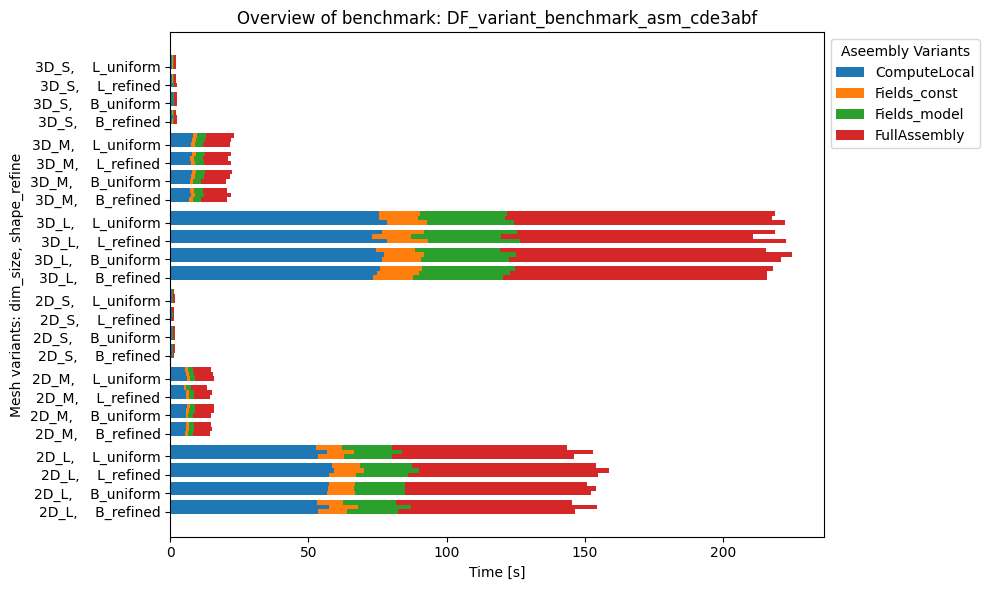

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

def mesh_cases_plot(df, time_label):
    """
    Plot the total test time as a function of 
    8 mesh cases (2 uniformity * 2 shape * 2 dimension)
    and mesh_size.
    Normalization by number of mesh elements (or number of function calls) is necessary. 
    """  
    
    stacked_df = df.groupby(['dim_size', 'mesh_type', 'run_id', 'variant'])['time'].sum().unstack('variant').fillna(0)
    # for grouping by position on Y axis
    level_labels = [l for l in stacked_df.index.levels]
    level_vals = [pd.Categorical(l).codes for l in stacked_df.index.levels]
    int_df = stacked_df.copy()
    int_df.index = stacked_df.index.set_levels(level_vals, level=[0, 1, 2])

    bar_width = 0.5
    steps = []
    ticks = []
    tick_labels = []
    last_idx = (0,-1,-1)
    step = np.array([0.5, 0.5, bar_width])
    for idx in int_df.index.drop_duplicates():
        diff = np.array(idx) - np.array(last_idx)
        last_idx = idx
        if diff[1] != 0:
            ticks.append(len(steps))
            tick_labels.append(f'{level_labels[0][idx[0]]}, {level_labels[1][idx[1]]: >12}')
        steps.append(np.sum(step[diff != 0]))
        
    positions = np.cumsum(steps)
    ticks = positions[ticks]        
        
    #print(positions)
        
    n_rows = len(stacked_df)
    #display(stacked_df)
    
   # Initialize a color palette
    palette = sns.color_palette("tab10", len(stacked_df.columns))
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
  
    # Create stacked bars
    bottom = np.zeros(n_rows)
    for j, col in enumerate(stacked_df.columns):
            ax.barh(positions, stacked_df[col], bar_width, left=bottom, color=palette[j], label=col)
            bottom += stacked_df[col]
    
    # # Set y-ticks to be in the middle of the group
    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels)
    
    # # Legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:len(stacked_df.columns)], stacked_df.columns, 
              title='Aseembly Variants', bbox_to_anchor=(1, 1), loc='upper left')
    
    # X-axis label
    plt.xlabel(time_label)
    plt.ylabel('Mesh variants: dim_size, shape_refine')
    plt.title(f'Overview of benchmark: {flow123d_version}')
    
    # Display
    plt.tight_layout()
    plt.show()
    

df_sumrun = df[df['tag'] == 'full_mesh'].copy()
df_sumrun['dim_size'] = df_sumrun['dim'] + '_' + df_sumrun['size']
def variant(row):
    var = row['assembly_variant']
    if var == 'EvalFields':
        var = f"Fields_{row['field_variant']}"
    return var

df_sumrun['variant'] = df.apply(variant, axis=1)
mesh_cases_plot(df_sumrun, 'Time [s]')

## Relative Mesh comparison
Comparison of time per element allows us to see:

- nearly no difference between mesh sizes, i.e., almost zero assembly overhead or
  additional 'fit to the cache' advantages of small meshes.
  Fitting all to the cache probably could not happen as individual data are allocated at different places.
  It seems more probable that even for small meshes (S ~ 1000 elements)
  the calculation has some cache misses. Needs better investigation.

- significant impact of 3D calculation. 3D has about 4/3 times more DOFs, the increase is slightly higher,
  possibly due to a larger increase in the number of quadrature points o
  
- very small impact of `mesh_type`

- the significant impact of `run_id` we should rather increase the number of runs to 5. Memory layout could
  have some impact. Ideally, we should minimize this impact by own arena allocator used for
  assembly structures on the patch.   

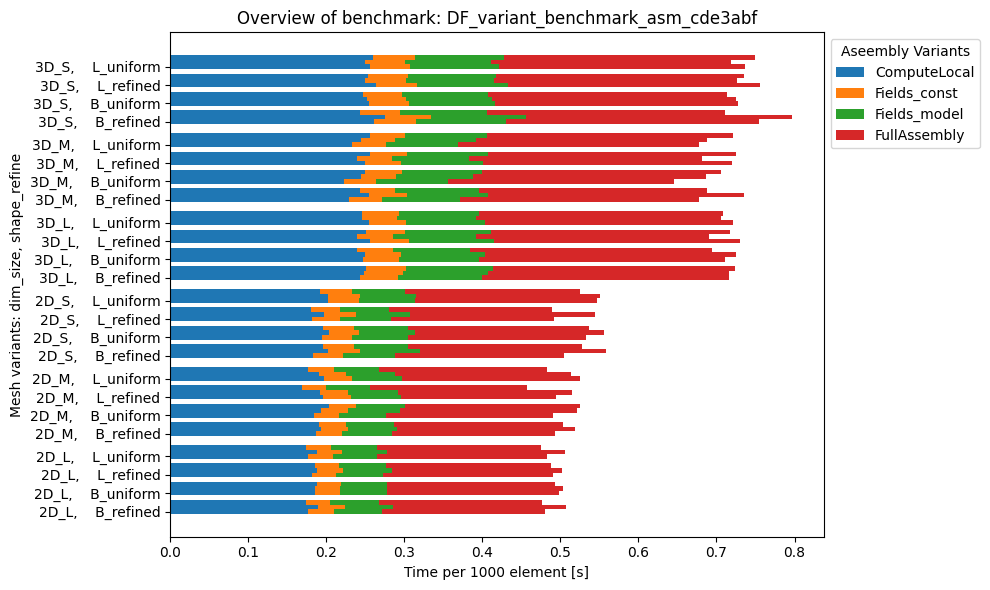

In [126]:
df_reltime = df_sumrun.copy()
df_reltime['time'] = df_reltime['time'] / df_reltime['n_el'] * 1000
mesh_cases_plot(df_reltime, 'Time per 1000 element [s]')

In [65]:


# In order to mimick dg_transport, benchmark use zero_time_step and 4 calls of update_solution. 
# Therefore initially there were two items for every group. One with n_calls==1 (zero_time_step) 
# and one with n_calls=4 (4 x update_solution). The loading script has been hacked to skip "ZERO-TIME STEP" tag
# However all tags excepting "full_mesh" are called in 4 assembly loops.

index_cols = ['dim', 'mesh_type', 'size', 'assembly_variant', 'field_variant', 'assembly_class', 'integral_type', 'tag']
grouped = df.groupby(index_cols)
#print(grouped.size())
assert all(grouped.size() == 3)
# Available groups
# print(grouped.groups.keys())
# Rows in a single group:
# display(grouped.get_group(('2D', 'B_refined', 'L', 'ComputeLocal', 'model', 'Mass', '', 'MassAssembly')))

def get_median_row(group):
    min_t = group['time'].min()
    median_t = group['time'].median()
    max_t = group['time'].max()
    row = group[group['time'] == min_t]
    row['Err'] = (median_t - min_t) / min_t
    return row

# Apply the custom function to each group
df_med = grouped.apply(get_median_row).reset_index(drop=True)
#display(result)
df_med.drop(columns=['run_id'], inplace=True)


# Sort the DataFrame by column 'A'
# There are many items with big error and big time fraction.
sorted_df = df_med.sort_values(by='Err', ascending=False)
big_err = sorted_df[sorted_df['Err'] > 0.1]
big_err_and_fraction = big_err[big_err['time_fraction'] > 0.05]
# Display the sorted DataFrame
display(big_err_and_fraction.head(30))


# Result kee run_id and try to plot all three values in plots.

,size,dim,n_el,field_variant,assembly_variant,assembly_class,tag,n_calls,integral_type,time,time_fraction,time_fraction_of_reminder,parent_tag,level,mesh_type,Err
1639,M,3D,31423,const,EvalFields,Sources,assemble_volume_integrals,1700,cell,0.004627,0.064983,NaN,SourcesAssembly,9,B_uniform,0.262325
1054,M,2D,30186,model,EvalFields,Mass,create_patch,1220,,0.016018,0.163491,NaN,MassAssembly,9,L_uniform,0.218199
1486,S,3D,3041,model,FullAssembly,Sources,cache_update,168,,0.001285,0.062361,NaN,SourcesAssembly,9,B_refined,0.197456
1931,M,3D,30574,const,EvalFields,Mass,assemble_volume_integrals,1656,cell,0.004842,0.066232,NaN,MassAssembly,9,L_refined,0.188246
725,M,2D,29250,const,EvalFields,,full_mesh,1,,0.888285,0.999999,NaN,EvalFields_const,5,L_refined,0.181281
260,S,2D,2918,model,EvalFields,Sources,add_integrals_to_patch,11672,,0.003043,0.424983,NaN,SourcesAssembly,9,B_refined,0.168463
451,M,2D,30168,model,EvalFields,Mass,MassAssembly,4,,0.101697,0.088873,0.102201,assembly,8,B_uniform,0.154284
718,M,2D,29250,model,ComputeLocal,Stiffness,add_integrals_to_patch,120260,,0.176840,0.053228,NaN,StiffnessAssembly,9,L_refined,0.148648
1554,L,3D,310479,model,EvalFields,Mass,create_patch,16784,,0.188990,0.126537,NaN,MassAssembly,9,B_uniform,0.146808
2202,M,3D,31914,model,ComputeLocal,Mass,add_integrals_to_patch,129380,,0.037948,0.081918,NaN,MassAssembly,9,L_uniform,0.143790


In [45]:
# reduce columns: assembly_variant, field_variant, integral_type
# to tags: 
# field_const, field_model
# <integral>_loop, <integral>_local, <integral>_global
# reminder (of assembly)

new_rows = {}

def add_row(group, orig_row_mask, tag, time_subtrack):
    new_row = group[orig_row_mask].to_dict('records')[0]
    
    #print(new_row)
    orig_time = new_row['time']
    new_row['time'] -= time_subtrack
    new_row['tag'] = tag
    for key, item_dict in new_row.items():
        new_rows.get(key, []).append(item_dict)
    return orig_time
    

# check same time of some tags between variants
index_cols = ['run_id', 'dim', 'mesh_type', 'size',  'assembly_class']
grouped = df.groupby(index_cols)

# Add column with assembly total times
#
for name, group in grouped:
    # skip full_mesh group
    if name[-1] == '':
        assert all(group['tag'] == 'full_mesh')
        continue
    asm_var = group['assembly_variant']    
    field_var = group['field_variant']
    tags = group['tag']
    integral = group['integral_type']

    #t_field_const = group[asm_var == 'EvalFields' & tag == 'cache_update' & field_var == 'const']['time']
    field_const_mask = (asm_var == 'EvalFields') & (tags == 'cache_update') & (field_var == 'const')
    t_field_const = add_row(group, field_const_mask, 'field_const', 0.0)
    field_model_mask = (asm_var == 'EvalFields') & (tags == 'cache_update') & (field_var == 'model')
    add_row(group, field_model_mask, 'field_model',  t_field_const)
    
    for it in integral.unique():
        loop_mask = (asm_var == 'EvalFields') & (integral == it)
        t_loop = add_row(group, loop_mask, f'{it}_loop', 0.0)
        local_mask = (asm_var == 'ComputeLocal') & (integral == it)
        t_local = add_row(group, local_mask, f'{it}_local', t_loop)
        global_mask = (asm_var == 'FullAssembly') & (integral == it)
        add_row(group, global_mask, f'{it}_global', t_local)
        

    


In [ ]:
 Extract coarse tags ("full_mesh", "" )

## Simplify columns
mesh spec: 
   - dim
   - mesh_shape (shape, uniformity)
   - mesh_size
assembly:
   - assembly_class
   - asm_child (compute: cacheupdate_base, asm_loop, asm_local, asm_global, reminder)
data columns:
   - time
   - fraction of assembly

In [6]:
print("tags: ", df['tag'].unique())

def simplify_cols(df):

    # append assembly childs:
    # cache_

tags:  ['full_mesh' 'StiffnessAssembly' 'add_integrals_to_patch' 'create_patch'
 'cache_update' 'assemble_volume_integrals' 'assemble_fluxes_boundary'
 'assemble_fluxes_elem_elem' 'assemble_fluxes_elem_side' 'MassAssembly'
 'SourcesAssembly']


In [4]:






def check_eq(array, runs):
    zip(runs, array)



def fix_types(df):
    categorical = []
    for col in df.columns:
        if all([type(v) is str for v in value_set]):
            # categorical col
            categorical.append(col)
        else:
            df[col] = 


def adapt_columns(df):
    """
    - turn '' into NaN in numerical columns
    - pr
    """
    df['n_mesh_elements'] = [int(n) for n in df['n_mesh_elements']]
    df['number_of_calls'] = [int(n) for n in df['number_of_calls']]
    
    # add calls
    #df['n_calls'] = 1
    
    # remove columns, set index
    df.drop(columns=['n_repeats', 'assembly_class',], inplace=True)
    df.set_index(['commit', 'spacedim', 'domain_shape', 'uniformity',  'mesh_size', 'run_id'], inplace=True)
    
    #code_map['']
    #df['code'] = [code_map[av] for av in df['assembly_variant']]
    return df
    pass



#df = apply_n_repeats(df, repeated_cols)
#df = apply_runs(df, repeated_cols)

table_overview(df)
domain_shape mesh_size spacedim uniformity assembly_class tag

SyntaxError: invalid syntax (2580138914.py, line 29)

# Overall structure
Let us compare individual meshes and their composition from assembly classes.

In [39]:
def top_tags(df):
    """
    Extract just top level tags passing over the whole mesh.
    """
    top_tags = {'full_mesh', 'MassAssembly', 'StiffnessAssembly', 'SourcesAssembly'}
    df['Variants'] = df.apply(lambda row: f"{row['field_variant']}_{row['assembly_variant']}", axis=1)
    df2 = df[df['tag'].isin(top_tags)].copy()
    
    df2.dropna(axis='columns', how='all', inplace=True)
    return df2[['Variants', 'tag', 'time']]
    
df_top_tags = top_tags(df)
display(df_top_tags)

unique_combinations = df_top_tags.index.unique()

# Iterate over unique combinations
for idx in unique_combinations:
    sub_df = df_top_tags.loc[idx]
    t_full_mesh = sub_df[sub_df.tag == 'full_mesh'].loc[0, 'time']
    sub_tags = sub_df[sub_df.tag != 'full_mesh']
    t_sub_tags = sub_tags.time.sum()
    df_top_tags
    display(sub_df)
    break

Variants  \
commit  spacedim domain_shape uniformity mesh_size run_id                     
a044dad 2D       B            uniform    small     1                nan_nan   
                                         medium    1                nan_nan   
                                         big       1                nan_nan   
                              refined    small     1                nan_nan   
                                         medium    1                nan_nan   
...                                                                     ...   
        3D       L            refined    big       3       const_EvalFields   
                                                   3       const_EvalFields   
                                                   3       model_EvalFields   
                                                   3       model_EvalFields   
                                                   3       model_EvalFields   

                                                                         tag  \
commit  spacedim domain_shape uniformity mesh_size run_id                      
a044dad 2D       B            uniform    small     1               full_mesh   
                                         medium    1               full_mesh   
                                         big       1               full_mesh   
                              refined    small     1               full_mesh   
                                         medium    1               full_mesh   
...                                                                      ...   
        3D       L            refined    big       3       StiffnessAssembly   
                                                   3         SourcesAssembly   
                                                   3            MassAssembly   
                                                   3       StiffnessAssembly   
                                                   3         SourcesAssembly   

                                                                 time  
commit  spacedim domain_shape uniformity mesh_size run_id              
a044dad 2D       B            uniform    small     1         1.219523  
                                         medium    1        11.433362  
                                         big       1       116.670933  
                              refined    small     1         1.171866  
                                         medium    1        11.120954  
...                                                               ...  
        3D       L            refined    big       3         4.477850  
                                                   3         0.562673  
                                                   3         1.341616  
                                                   3        15.072928  
                                                   3         0.677276  

[936 rows x 3 columns]

/tmp/ipykernel_169670/2970317765.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  sub_df = df_top_tags.loc[idx]


KeyError: 0

['full_mesh']


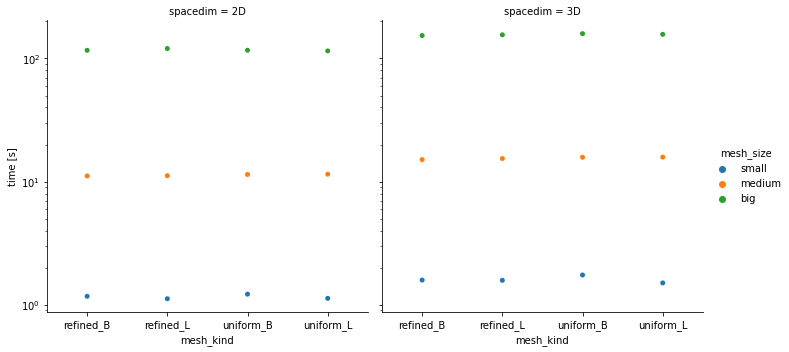

,commit,run_id,domain_shape,uniformity,spacedim,mesh_size,field_variant,assembly_variant,assembly_class,tag,integral_type,time,time_fraction,time_fraction_of_reminder,assembly,n_elements,n_calls
1039,a044dad,1,B,uniform,3D,small,const,FullAssembly,StiffnessAssembly,StiffnessAssembly,None,0.419191,0.000000,0.067148,Stiffness,1000,0.1
1040,a044dad,1,B,uniform,3D,small,const,FullAssembly,StiffnessAssembly,create_patch,None,0.016046,0.038278,0.000000,Stiffness,1000,0.1
1041,a044dad,1,B,uniform,3D,small,const,FullAssembly,StiffnessAssembly,cache_update,None,0.004211,0.010046,0.000000,Stiffness,1000,0.1
1042,a044dad,1,B,uniform,3D,small,const,FullAssembly,StiffnessAssembly,assemble_volume_integrals,cell,0.067765,0.161656,0.000000,Stiffness,1000,0.1
1043,a044dad,1,B,uniform,3D,small,const,FullAssembly,StiffnessAssembly,assemble_fluxes_boundary,boundary,0.014528,0.034658,0.000000,Stiffness,1000,0.1
1044,a044dad,1,B,uniform,3D,small,const,FullAssembly,StiffnessAssembly,assemble_fluxes_elem_elem,edge,0.288426,0.688055,0.000000,Stiffness,1000,0.1
1045,a044dad,1,B,uniform,3D,small,const,FullAssembly,StiffnessAssembly,assemble_fluxes_elem_side,dimjoin,0.000067,0.000159,0.000000,Stiffness,1000,0.1
1060,a044dad,1,B,uniform,3D,small,const,ComputeLocal,StiffnessAssembly,StiffnessAssembly,None,0.341010,0.000000,0.076213,Stiffness,1000,0.1
1061,a044dad,1,B,uniform,3D,small,const,ComputeLocal,StiffnessAssembly,create_patch,None,0.015920,0.046685,0.000000,Stiffness,1000,0.1
1062,a044dad,1,B,uniform,3D,small,const,ComputeLocal,StiffnessAssembly,cache_update,None,0.004137,0.012132,0.000000,Stiffness,1000,0.1


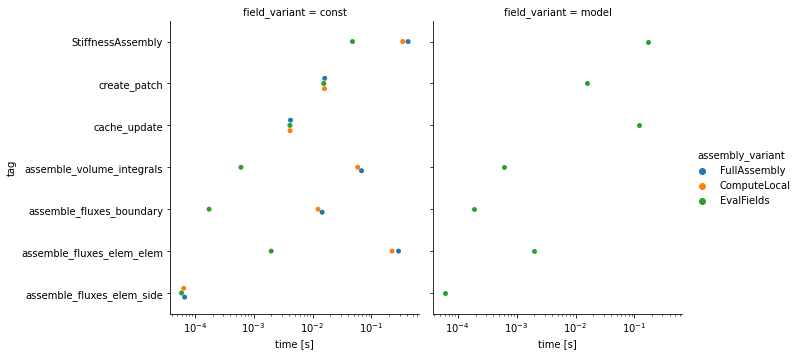

In [23]:
"""
Preliminary results:
- create_patch and cache_update are independent of assembly variant, can use mean value of these
- assembly is independent of field_update kind

- create_patch is takes significantly more then const field update
- empty assembly (just iterate over pathc elements) dominated by edge integral 
  pass 
- need some mesh with dimjoins

TODO:
- reminder = Assembly tag - other 6 subtags x 4 assembly variants
- patch = mean over assembly variants and field_kind
- f_const = mean over assembly variants field_kind == const
- f_model = field_kind == model
- integral (cell, edge, boundary, dimjoin) x phase (loop, local, assembly)
  

- 4 assembly variants: f_const, f_model, local=ComputeLocal - f_const, full = FullAssembly  - ComputeLocal
- 7 tags: patch, cache, cell, edge, boundary, dimjoin, reminder
- further simplify the cartesian product to:
    - patch (mean over assembly)
"""

dd = df[df.assembly_class == 'StiffnessAssembly']
dd = dd[dd.spacedim == '3D']
dd = dd[dd.uniformity == 'uniform']
dd = dd[dd.mesh_size == 'small']
dd = dd[dd.domain_shape == 'B']
dd = dd[dd.run_id == 1]
display(dd)

import seaborn as sns
def single_assembly_items(df):
    """
    Plot the total test time as a function of 
    8 mesh cases (2 uniformity * 2 shape * 2 dimension)
    and mesh_size.
    Normalization by number of mesh elements (or number of function calls) is necessary. 
    """  
    fgrid = sns.catplot(y='tag', x='time', hue='assembly_variant', 
                col='field_variant', kind='swarm', data=df)
    fgrid.set_xlabels('time [s]')
    fgrid.set(xscale='log')

def assembly_blocks(df):
    """
    For every XYZAssembly tag:
    - collect corresponding subtags for both field
    - patch 
    """
    pass
single_assembly_items(dd)

In [12]:
# Print values of distrete columns:
for c in df.columns:
    if df[c].dtype.name == 'object':
        print(c, '  values:', df[c].unique())

commit   values: ['a044dad']
domain_shape   values: ['B' 'L']
uniformity   values: ['uniform' 'refined']
spacedim   values: ['2D' '3D']
mesh_size   values: ['small' 'medium' 'big']
field_variant   values: [nan 'const' 'model']
assembly_variant   values: [nan 'FullAssembly' 'ComputeLocal' 'EvalFields']
assembly_class   values: [nan 'MassAssembly' 'StiffnessAssembly' 'SourcesAssembly']
tag   values: ['full_mesh' 'MassAssembly' 'create_patch' 'cache_update'
 'assemble_volume_integrals' 'assemble_fluxes_boundary'
 'assemble_fluxes_elem_elem' 'assemble_fluxes_elem_side'
 'StiffnessAssembly' 'SourcesAssembly']
integral_type   values: [None 'cell' 'boundary' 'edge' 'dimjoin']
assembly   values: [None 'Mass' 'Stiffness' 'Sources']


# Confirm duplicity of tag and integral

In [11]:
tag_int_code_pairs = [
    ('assemble_volume_integrals', 'cell'),
    ('assemble_fluxes_boundary', 'boundary'),
    ('assemble_fluxes_elem_elem', 'edge'),
    ('assemble_fluxes_elem_side', 'dimjoin')]
for tag,integral in tag_int_code_pairs:
    mask = df['tag'] == tag
    print(tag, '==' , integral, all(df.loc[mask, 'integral_type'] == integral))

assemble_volume_integrals == cell True
assemble_fluxes_boundary == boundary True
assemble_fluxes_elem_elem == edge True
assemble_fluxes_elem_side == dimjoin True


code : patch, field const, field model, local, assembly
integral (subfactor for local and assembly): cell, edge, boundary, dimjoin
together 3 + 4 + 4 code sections

assembly: Stiffness, Mass, Sources
mesh_type: 8
mesh_size: 3

hypotheses:
patch and fields independent of integral and mesh type
local and assembly 

view:
code as portions of a bar graph


{'Whole Program': {'square_2D_uniform': {'small': {'FullAssembly_const': {'BaseMeshReader - mesh factory': {'MESH - optimizer': {}, 'MESH - setup topology': {'duplicate_nodes': {}, 'Mesh::output_internal_ngh_data': {}}}, 'ZERO-TIME STEP': {'data initialize': {}, 'assembly': {'StiffnessAssembly': {'create_patch': {}, 'cache_update': {}, 'assemble_volume_integrals': {}, 'assemble_fluxes_boundary': {}, 'assemble_fluxes_elem_elem': {}, 'assemble_fluxes_elem_side': {}}, 'MassAssembly': {'create_patch': {}, 'cache_update': {}, 'assemble_volume_integrals': {}, 'assemble_fluxes_boundary': {}, 'assemble_fluxes_elem_elem': {}, 'assemble_fluxes_elem_side': {}}, 'SourcesAssembly': {'create_patch': {}, 'cache_update': {}, 'assemble_volume_integrals': {}, 'assemble_fluxes_boundary': {}, 'assemble_fluxes_elem_elem': {}, 'assemble_fluxes_elem_side': {}}}}, 'SIMULATION-ONE STEP': {'data reinit': {}, 'assembly': {'MassAssembly': {'create_patch': {}, 'cache_update': {}, 'assemble_volume_integrals': {}, '

AttributeError: 'float' object has no attribute 'items'

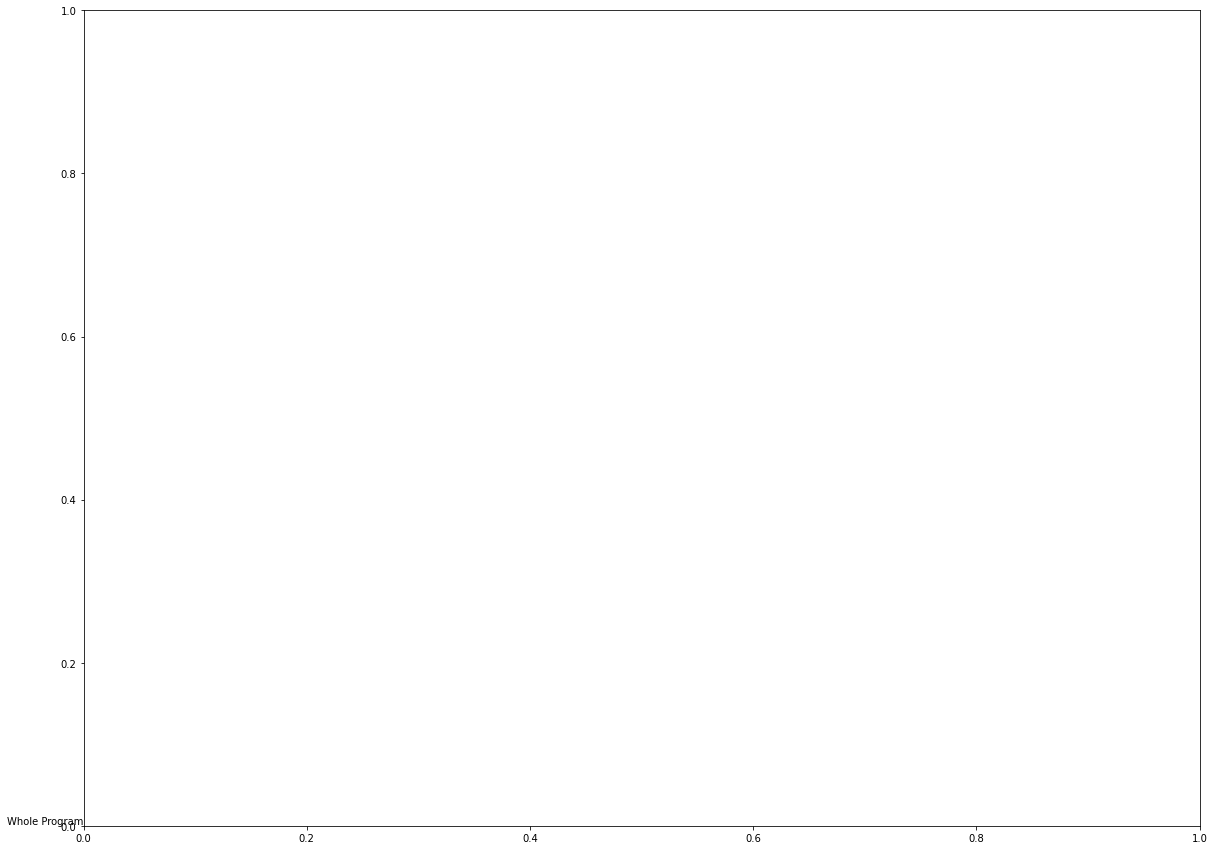

In [105]:
import json
# Display program tag-tree from original profiler output
def load_profiler(fname):
    with open(fname, 'r') as f:
        content = json.load(f)
    return content
        
prof = load_profiler(input_file_base + ".json")

def none_fn(node):
    return None

def iter_prof(node, fn = none_fn):
    childs = node.get('children', [])
    d = {c['tag']: iter_prof(c) for c in childs}
    node_value = fn(node)
    if node_value is not None:
        d['!value'] = node_value 
    return d

def tag_dict(root_node):
    return iter_prof(root_node)

import matplotlib.pyplot as plt

def plot_tree(ax, d, x=0, y=0, level_height=0.1, x_offset=0.1):
    for key, value in d.items():
        ax.text(x, y, key, verticalalignment='bottom', horizontalalignment='right')
        
        new_y = y - level_height

        if isinstance(value, dict):
            #ax.plot([x, x + x_offset], [y - 0.1, new_y + 0.1], 'k-')  # Vertical line
            #ax.plot([x, x + x_offset], [new_y + 0.1, new_y + 0.1], 'k-')  # Horizontal line

            plot_tree(value, x + x_offset, new_y, level_height, x_offset, ax)

        y = new_y
    ax.axis('off')    
    
def display_code(prof):
    fig, ax = plt.subplots(figsize=(20,15))
    plot_tree(ax, prof)
    return fig, ax

td = tag_dict(prof)
print(td)
fig, ax = display_code(td)
plt.show()

In [ ]:
See if we have any large unidentified blocks

The code structure is like:
    - full_mesh
       - some other stuff (should be minor)
       - MassAssembly
       - SourcesAssembly
       - StiffnessAssembly 

In [70]:
def full_mesh(df):
    df2 = df[df['tag'] == 'full_mesh'].copy()
    df2.dropna(axis='columns', how='all', inplace=True)
    return df2
    
df_full_mesh = full_mesh(df)
display(df_full_mesh)

,commit,run_id,domain_shape,uniformity,spacedim,mesh_size,tag,time,n_elements,n_calls
0,a044dad,1,B,uniform,2D,small,full_mesh,1.219523,1000,0.1
1,a044dad,1,B,uniform,2D,medium,full_mesh,11.433362,2000,1.0
2,a044dad,1,B,uniform,2D,big,full_mesh,116.670933,3000,1.0
3,a044dad,1,B,refined,2D,small,full_mesh,1.171866,1000,0.1
4,a044dad,1,B,refined,2D,medium,full_mesh,11.120954,2000,1.0
...,...,...,...,...,...,...,...,...,...,...
4099,a044dad,3,L,uniform,3D,medium,full_mesh,15.806246,2000,1.0
4100,a044dad,3,L,uniform,3D,big,full_mesh,157.303360,3000,1.0
4101,a044dad,3,L,refined,3D,small,full_mesh,1.577268,1000,0.1
4102,a044dad,3,L,refined,3D,medium,full_mesh,15.284970,2000,1.0


Goals of analysis:
- time of individual phases: field_const, field_model, local_matrix, assembly
  as function of the mesh size; Use ANOVA to see if the shape or uniformity of the domain 
  affects the time
- plot total mesh time as function of (mesh type (uniformity, dimension, shape), mesh_size)
- collect mesh types that seems to behave in the same way

  log T = log mu_{cases,tag} + log mu_size
  vs. interaction so the tags scale differently with size (different portion of the const overhead)
  
Improve the collectiong process:
- fix the column names
- add #calls column 

In [56]:
from collections import defaultdict

def check_same(x, y):
    if x != y:
        return None
    return x

def my_med(x):
    print(x)
    return np.median(x)

def median_keep_nan(series):
    if all(pd.isna(series)):
        return np.nan
    return series.median()
    
def aggregate_runs(df, columns, op=median_keep_nan):
    # how to apply common function to all other columns
    operation_col_dict = defaultdict(lambda : check_same)
    for c in time_cols & set(df.columns):
        operation_col_dict[c] = op
    
    
    group_by_cols = set(df.columns.values) - {'run_id'} - time_cols
    groups = df.groupby(list(group_by_cols))
    #for name, group in groups:
    #    print(name)
    #    print(group)
    return groups.agg(operation_col_dict)

time_cols = {'time', 'time_fraction', 'time_fraction_of_reminder'}

df = df.reset_index()
df_sumrun = aggregate_runs(df, time_cols)
display(df_sumrun.reset_index())
#df_sumrun.columns
#print(df_sumrun.index.get_level_values('tag').unique())

,n_calls,assembly_variant,domain_shape,commit,Variants,tag,field_variant,n_elements,mesh_size,uniformity,integral_type,spacedim,index,assembly,time,time_fraction,time_fraction_of_reminder
0,0.1,ComputeLocal,B,a044dad,const_ComputeLocal,assemble_fluxes_boundary,const,1000,small,refined,boundary,2D,301,Mass,0.000012,0.000732,0.0
1,0.1,ComputeLocal,B,a044dad,const_ComputeLocal,assemble_fluxes_boundary,const,1000,small,refined,boundary,2D,308,Stiffness,0.005128,0.019570,0.0
2,0.1,ComputeLocal,B,a044dad,const_ComputeLocal,assemble_fluxes_boundary,const,1000,small,refined,boundary,2D,315,Sources,0.000012,0.001139,0.0
3,0.1,ComputeLocal,B,a044dad,const_ComputeLocal,assemble_fluxes_boundary,const,1000,small,refined,boundary,2D,2341,Mass,0.000012,0.000709,0.0
4,0.1,ComputeLocal,B,a044dad,const_ComputeLocal,assemble_fluxes_boundary,const,1000,small,refined,boundary,2D,2348,Stiffness,0.005154,0.019421,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3451,1.0,FullAssembly,L,a044dad,const_FullAssembly,assemble_volume_integrals,const,3000,big,uniform,cell,3D,3754,Stiffness,6.155830,0.158154,0.0
3452,1.0,FullAssembly,L,a044dad,const_FullAssembly,assemble_volume_integrals,const,3000,big,uniform,cell,3D,3761,Sources,1.167425,0.694035,0.0
3453,1.0,FullAssembly,L,a044dad,const_FullAssembly,assemble_volume_integrals,const,3000,big,uniform,cell,3D,5787,Mass,3.411887,0.870409,0.0
3454,1.0,FullAssembly,L,a044dad,const_FullAssembly,assemble_volume_integrals,const,3000,big,uniform,cell,3D,5794,Stiffness,6.198350,0.158468,0.0


In [27]:
d2 = pd.DataFrame(df)
d2['mesh_kind'] = d2['uniformity'] + "_" + d2['domain_shape']

In [28]:
display(df)

,commit,run_id,domain_shape,uniformity,spacedim,mesh_size,n_repeats,field_variant,assembly_variant,assembly_class,tag,integral_type,time,time_fraction,time_fraction_of_reminder,n_elements,n_calls,mesh_kind
0,a044dad,1,square,uniform,2D,small,10,NaN,NaN,NaN,full_mesh,NaN,12.195230,NaN,NaN,1000,1,uniform_square
1,a044dad,1,square,uniform,2D,medium,1,NaN,NaN,NaN,full_mesh,NaN,11.433362,NaN,NaN,2000,1,uniform_square
2,a044dad,1,square,uniform,2D,big,1,NaN,NaN,NaN,full_mesh,NaN,116.670933,NaN,NaN,3000,1,uniform_square
3,a044dad,1,square,refined,2D,small,10,NaN,NaN,NaN,full_mesh,NaN,11.718664,NaN,NaN,1000,1,refined_square
4,a044dad,1,square,refined,2D,medium,1,NaN,NaN,NaN,full_mesh,NaN,11.120954,NaN,NaN,2000,1,refined_square
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6115,a044dad,3,lshape,refined,3D,big,1,model,EvalFields,SourcesAssembly,cache_update,NaN,0.106648,0.157467,0.0,3000,1,refined_lshape
6116,a044dad,3,lshape,refined,3D,big,1,model,EvalFields,SourcesAssembly,assemble_volume_integrals,cell_integral,0.042696,0.063042,0.0,3000,1,refined_lshape
6117,a044dad,3,lshape,refined,3D,big,1,model,EvalFields,SourcesAssembly,assemble_fluxes_boundary,boundary_side_integral,0.001640,0.002421,0.0,3000,1,refined_lshape
6118,a044dad,3,lshape,refined,3D,big,1,model,EvalFields,SourcesAssembly,assemble_fluxes_elem_elem,edge_integral,0.001548,0.002286,0.0,3000,1,refined_lshape


In [26]:
def mesh_cases_anova(df):
    """
    
    all_mesh_time/ = log mu_{cases,tag} + log mu_size
    """


Clearly there is a negligeble overall difference between the meshes. Let's try ANOVA for different 'tag' and 'assembly_variant' cases.